In [1]:
import time
from pathlib import Path

import numpy as np
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from jaxpower import (compute_mesh_power, PowerSpectrumMultipoles, generate_gaussian_mesh, generate_anisotropic_gaussian_mesh, generate_uniform_particles, RealMeshField, ParticleField, FKPField,
                      compute_fkp_power, BinnedStatistic, WindowMatrix, MeshAttrs, BinAttrs, compute_mean_mesh_power, compute_mesh_window, compute_normalization, utils, create_sharding_mesh, make_particles_from_local, create_sharded_array, create_sharded_random, compute_fkp_normalization_and_shotnoise)

attrs = MeshAttrs(meshsize=(256,) * 3, boxsize=1000., boxcenter=1200.)
size = int(1e-3 * attrs.boxsize.prod())

cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)

f, b = 0.8, 1.5
beta = f / b
kinedges = np.linspace(0.001, 0.7, 100)
kin = (kinedges[:-1] + kinedges[1:]) / 2.
ells = (0, 2, 4)
poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk(kin),
                    0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk(kin),
                    8. / 35 * beta ** 2 * pk(kin)])
theory = BinnedStatistic(x=[kin] * len(ells), edges=[kinedges] * len(ells), value=poles, projs=ells)

def generate_mock(seed):
    if isinstance(seed, int):
        seed = jax.random.key(seed)
    seeds = jax.random.split(seed)
    data = generate_uniform_particles(attrs, size + 1, seed=seeds[0])
    randoms = generate_uniform_particles(attrs, 4 * size + 1, seed=seeds[1])
    mesh = generate_anisotropic_gaussian_mesh(attrs, theory, seed=seeds[2], los='local', unitary_amplitude=True)
    data = data.clone(weights=1. + mesh.read(data.positions))
    return FKPField(data, randoms, **attrs.clone(boxsize=2. * attrs.boxsize))  # x2 padding


import jaxpower
compute_mesh_power = jax.jit(jaxpower.power.compute_mesh_power, static_argnames=['ells', 'los'])

def compute_power(fkp, nsplits=None):

    def compute_one(fkp, bin=None):
        norm, shotnoise_nonorm = compute_fkp_normalization_and_shotnoise(fkp)
        t0 = time.time()
        mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
        if bin is None: bin = BinAttrs(mesh.attrs, edges={'step': 0.01})
        jax.block_until_ready(mesh)
        t1 = time.time()
        toret = compute_mesh_power(mesh, bin=bin, ells=(0, 2, 4), los='firstpoint').clone(norm=norm, shotnoise_nonorm=shotnoise_nonorm), bin
        jax.block_until_ready(toret)
        print(f'paint {t1 - t0:.2f}; compute {time.time() - t1:.2f}')
        return toret

    if nsplits is None:
        return compute_one(fkp)[0]

    meshsize = fkp.attrs.meshsize // nsplits
    list_poles = {}
    for level, nsplits in enumerate([1, nsplits]):
        bin = None
        list_poles[level] = []
        for split_fkp in fkp.clone(meshsize=meshsize).split(nsplits=nsplits):
            split_poles, bin = compute_one(split_fkp, bin=bin)
            list_poles[level].append(split_poles)

    fnyq = 0.8
    split_poles, ksplits = [], []
    for level in list_poles:
        kmin = 0
        kmax = np.inf
        if level < len(list_poles) - 1: kmax = fnyq * list_poles[level][0].edges(projs=0).max()
        if split_poles: kmin = split_poles[-1].edges(projs=0).max()
        xlim = (kmin, kmax)
        ksplits.append(xlim)
        split_poles.append(list_poles[0][0].sum([poles.select(xlim=xlim) for poles in list_poles[level]]))
    poles = split_poles[0].concatenate(split_poles)
    poles.attrs['ksplits'] = ksplits
    return poles

In [2]:
fkp = generate_mock(42)
poles = compute_power(fkp, nsplits=None)
split_poles = compute_power(fkp, nsplits=2)

paint 3.57; compute 1.87
paint 3.58; compute 1.89
paint 2.25; compute 1.81
paint 2.04; compute 0.03
paint 1.95; compute 0.03
paint 1.84; compute 0.03
paint 2.53; compute 0.03
paint 1.80; compute 0.03
paint 2.10; compute 0.03
paint 2.10; compute 0.03


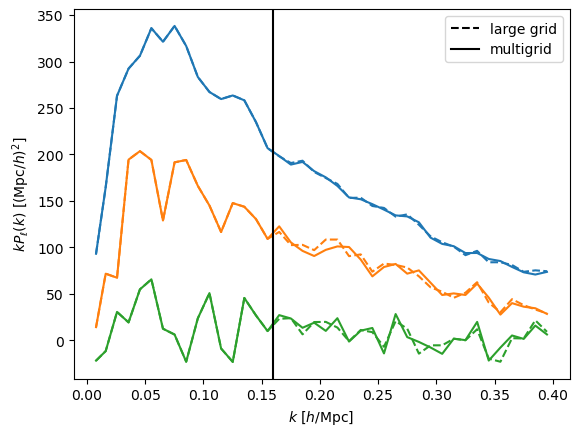

In [3]:
ax = plt.gca()
for iproj, proj in enumerate(poles.projs):
    color = 'C{:d}'.format(iproj)
    k = poles.x(projs=proj)
    ax.plot(k, k * poles.view(projs=proj).real, linestyle='--', color=color)
    k = split_poles.x(projs=proj)
    ax.plot(k, k * split_poles.view(projs=proj).real, linestyle='-', color=color)
ax.plot([], [], color='k', linestyle='--', label='large grid')
ax.plot([], [], color='k', linestyle='-', label='multigrid')
ax.axvline(x=split_poles.attrs['ksplits'][0][1], color='k')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
plt.show()

In [4]:
for i in range(1):
    fkp = generate_mock(i)
    jax.block_until_ready(fkp)
    t0 = time.time()
    poles = compute_power(fkp, nsplits=None)
    jax.block_until_ready(poles)
    t1 = time.time()
    split_poles = compute_power(fkp, nsplits=2)
    jax.block_until_ready(split_poles)
    t2 = time.time()
    print(f'standard {t1 - t0:.2f}; multigrid {t2 - t1:.2f}')

paint 1.81; compute 0.15
paint 1.76; compute 0.03
paint 1.99; compute 0.03
paint 2.08; compute 0.03
paint 2.34; compute 0.03
paint 1.85; compute 0.04
paint 1.89; compute 0.04
paint 2.09; compute 0.03
paint 2.10; compute 0.04
paint 1.89; compute 0.05
standard 2.16; multigrid 43.31
